# Multi Layer Perceptron

In [1]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline  
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))

# Device Configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("This notebook use [%s]."%(device))

PyTorch version:[1.7.0].
This notebook use [cuda:0].


# Set hyper-parameter

In [2]:
EPOCHS = 10
BATCH_SIZE=256
LEARNING_RATE=0.001

# Prepare dataset

In [3]:
# MNIST dataset
mnist_train = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=True)

train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

print("Preparing dataset done!")

Preparing dataset done!


# Defining Model

In [4]:
# our model
class Model(nn.Module):
    def __init__(self, input_features=784, hidden_size=256, output_fetures=10, init_weight="he", init_bias="zero"):
        super(Model, self).__init__()
        self.init_weight = init_weight
        self.init_bias = init_bias

        self.linear1 = nn.Linear(input_features, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_fetures)
        self.init_params()

    def init_params(self):
        
        init_weight_method = {
        "he": nn.init.kaiming_normal_, 
        "xavier": nn.init.xavier_normal_
        }
        assert self.init_weight in init_weight_method.keys(), f'Select the weight initialization method in {list(init_weight_method.keys())}'
        
        init_bias_method = {
            "zero": nn.init.zeros_, 
            "uniform": nn.init.uniform_
        }
        assert self.init_bias in init_bias_method.keys(), f'Select the bias initialization method in {list(init_bias_method.keys())}'

        for param_name, param in self.named_parameters():
            if 'weight' in param_name:
                print(param)
                init_weight_method[self.init_weight](param)
            elif 'bias' in param_name:
                init_bias_method[self.init_bias](param)

    def forward(self, X):
        X = F.relu((self.linear1(X)))
        X = self.linear2(X)
        return X

model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Parameter containing:
tensor([[-0.0347, -0.0311, -0.0162,  ...,  0.0229, -0.0098,  0.0316],
        [-0.0330,  0.0111, -0.0071,  ...,  0.0297, -0.0082,  0.0271],
        [ 0.0295,  0.0151,  0.0025,  ..., -0.0228, -0.0098, -0.0241],
        ...,
        [-0.0169, -0.0077, -0.0318,  ..., -0.0296,  0.0220, -0.0262],
        [ 0.0347, -0.0283,  0.0144,  ..., -0.0064, -0.0213, -0.0308],
        [ 0.0321,  0.0084, -0.0176,  ...,  0.0242,  0.0299, -0.0106]],
       requires_grad=True)
Parameter containing:
tensor([[ 0.0312,  0.0463,  0.0381,  ...,  0.0466,  0.0174, -0.0183],
        [ 0.0307, -0.0519, -0.0407,  ...,  0.0056,  0.0346,  0.0511],
        [-0.0075,  0.0622, -0.0301,  ...,  0.0595, -0.0460, -0.0192],
        ...,
        [-0.0322, -0.0366, -0.0424,  ...,  0.0260,  0.0530,  0.0194],
        [ 0.0145,  0.0271,  0.0502,  ...,  0.0076, -0.0126, -0.0366],
        [ 0.0609, -0.0152, -0.0399,  ..., -0.0258, -0.0541,  0.0443]],
       requires_grad=True)


In [5]:
total_params = 0
for param_name, param in model.named_parameters():
    if param.requires_grad:
        total_params += len(param.reshape(-1))
print(f"Number of Total Parameters: {total_params:,d}")

Number of Total Parameters: 203,530


# Define help function

In [6]:
def test_eval(model, data_iter, batch_size):
    with torch.no_grad():
        test_loss = 0
        total = 0
        correct = 0
        for batch_img, batch_lab in data_iter:
            X = batch_img.view(-1, 28*28).to(device)
            Y = batch_lab.to(device)
            y_pred = model(X)
            _, predicted = torch.max(y_pred.data, 1)
            correct += (predicted == Y).sum().item()
            total += batch_img.size(0)
        val_acc = (100 * correct / total)
    return val_acc

# Train MLP Model 

In [7]:
# Training Phase
print_every = 1
print("Start training !")
# Training loop
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_img, batch_lab in train_iter:

        X = batch_img.view(-1, 28*28).to(device)
        Y = batch_lab.to(device)
        
        # Inference & Calculate los
        y_pred = model.forward(X)
        loss = criterion(y_pred, Y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_val_sum += loss
        
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        # accr_val = M.test(x_test, y_test, batch_size)
        loss_val_avg = loss_val_sum / len(train_iter)
        accr_val = test_eval(model, test_iter, BATCH_SIZE)
        print(f"epoch:[{epoch+1}/{EPOCHS}] cost:[{loss_val_avg:.3f}] test_accuracy:[{accr_val:.3f}]")
print("Training Done !")

Start training !
epoch:[1/10] cost:[0.376] test_accuracy:[94.240]
epoch:[2/10] cost:[0.167] test_accuracy:[96.010]
epoch:[3/10] cost:[0.117] test_accuracy:[96.830]
epoch:[4/10] cost:[0.088] test_accuracy:[97.320]
epoch:[5/10] cost:[0.070] test_accuracy:[97.560]
epoch:[6/10] cost:[0.057] test_accuracy:[97.640]
epoch:[7/10] cost:[0.047] test_accuracy:[97.730]
epoch:[8/10] cost:[0.039] test_accuracy:[97.930]
epoch:[9/10] cost:[0.032] test_accuracy:[97.790]
epoch:[10/10] cost:[0.028] test_accuracy:[97.830]
Training Done !


# Test MLP Model

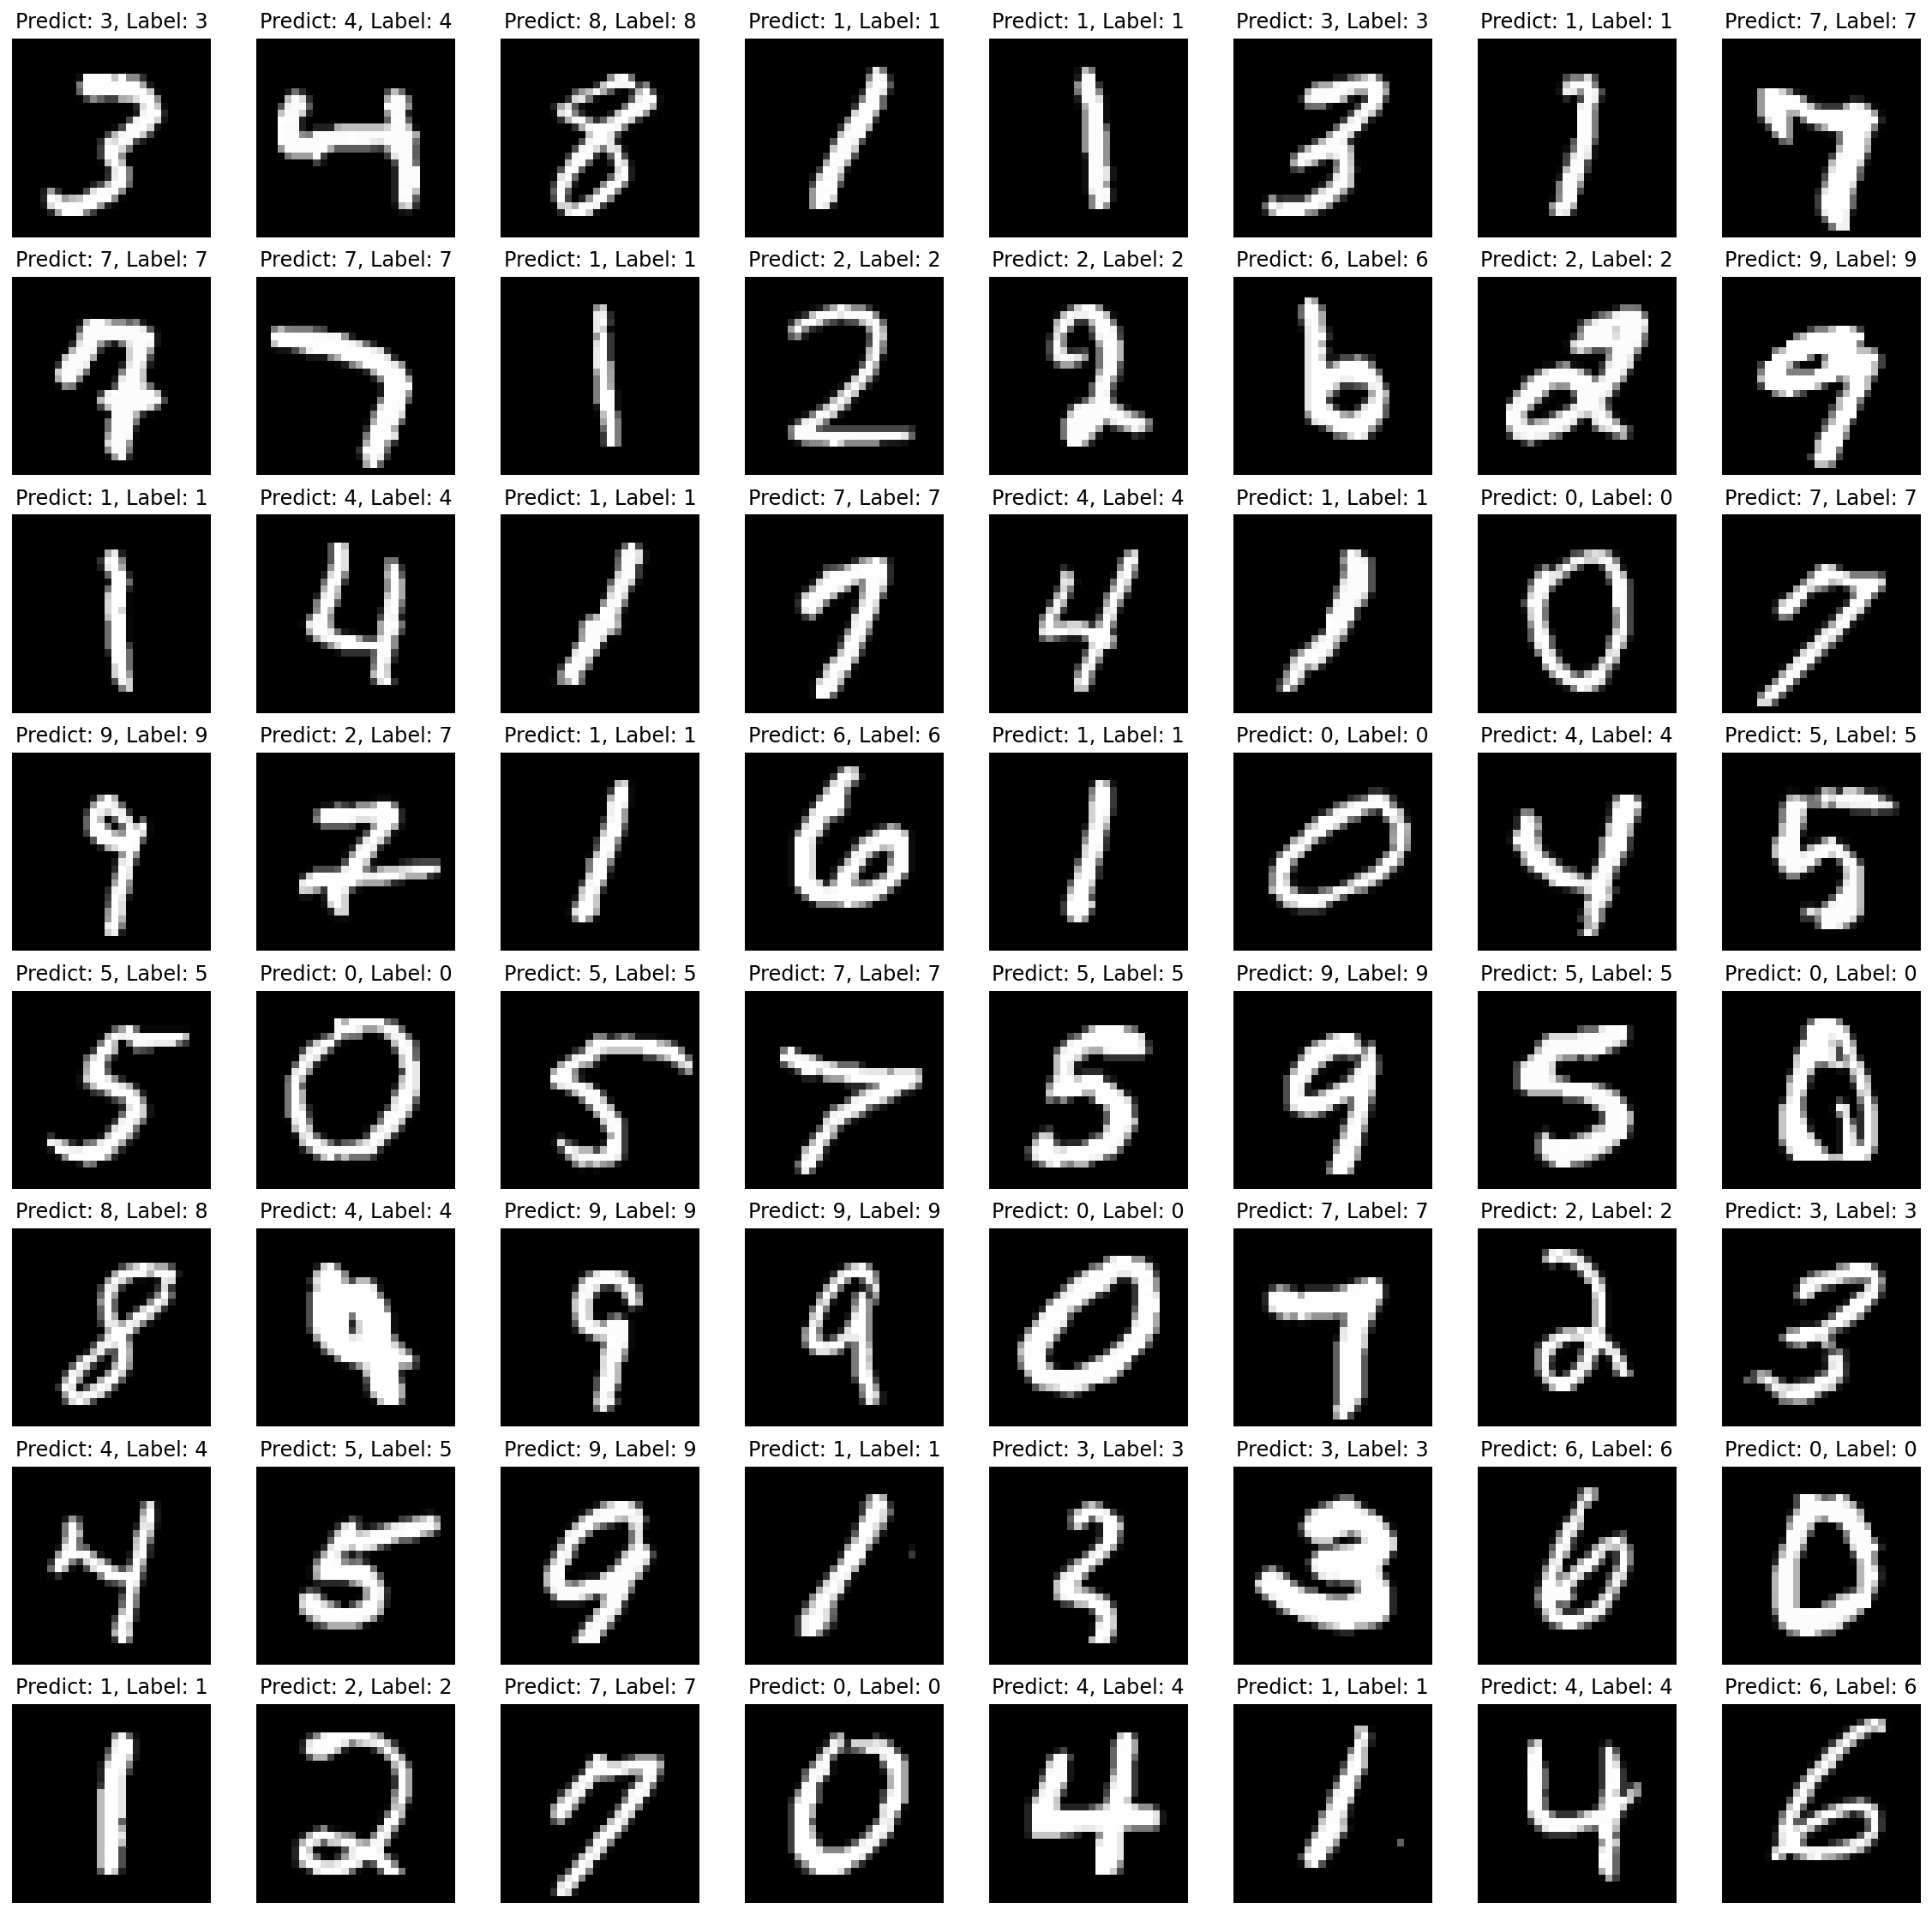

In [8]:
n_sample = 64
sample_indices = np.random.choice(len(mnist_test.targets), n_sample, replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]

with torch.no_grad():
    y_pred = model.forward(test_x.view(-1, 28*28).type(torch.float).to(device))

y_pred = y_pred.argmax(axis=1)

plt.figure(figsize=(20, 20))

for idx in range(n_sample):
    plt.subplot(8, 8, idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title(f"Predict: {y_pred[idx]}, Label: {test_y[idx]}")

plt.show()